# Pandas DataFrame, Series and num2date #
## Calculating seasonal cycle and anomalies

num2date(...) returns datetime objects given numeric time values. The function uses [CF Conventions and Metadata](http://cfconventions.org/)

In the following example we read in [atmospheric reanalysis data](http://icdc.zmaw.de/1/daten/reanalysis-atmosphere.html) in NetCDF format and plot the time series at some selected positions. We use the num2date module to efficiently decode the datetime from the meta-information. We demonstrate the use of Pandas functions for calculating the rolling mean and for selecting periods. Finally, we calculate seasonal cycles, anomalies and a linear regression of the anomalies. 

Example derived from http://earthpy.org/pandas_netcdf.html

In [26]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd
from netCDF4 import Dataset, num2date
import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [27]:
fn='/data/icdc/reanalyses/ncep_reanalysis1/DATA/2m_airtemp_monthly/air2m.mon.mean.nc'
fn='/home/lars/data/air2m.mon.mean.nc' # local copy on my laptop

f = Dataset(fn)
print(f.description)
print(f.References)
air = f.variables['air'][:]-273.15
time = f.variables['time']
lon = f.variables['lon'][:]
lat = f.variables['lat'][:]
date=pd.to_datetime(num2date(time[:], time.units)) # Convert to Pandas time object

Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html


In [28]:
D={'Hamburg':(10.0,53.3),'Equator':(0.0,0.0),'North Pole':(0,90.0)} # Define locations
DF=pd.DataFrame() # Create empty DataFrame table

for k in D.keys():
    lon0,lat0=D[k]
    ilon,ilat=argmin(abs(lon-lon0)),argmin(abs(lat-lat0)) # index for location
    # Generate Pandas Series Object and store in DataFrame
    DF[k]=pd.Series(air[:,ilat,ilon],index=date)

In [29]:
!ncdump $fn | head -n30

netcdf air2m.mon.mean {
dimensions:
	lat = 94 ;
	lon = 192 ;
	time = UNLIMITED ; // (814 currently)
variables:
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:actual_range = 88.542f, -88.542f ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
		lon:actual_range = 0.f, 358.125f ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
	double time(time) ;
		time:long_name = "Time" ;
		time:delta_t = "0000-01-00 00:00:00" ;
		time:avg_period = "0017-00-00 00:00:00" ;
		time:prev_avg_period = "0000-00-01 00:00:00" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:units = "hours since 1800-01-01 00:00:0.0" ;
		time:actual_range = 1297320., 1891200. ;
	float air(time, lat, lon) ;
		air:long_name = "Monthly Mean of Air Temperature" ;
		air:valid_range = 150.f, 400.f ;


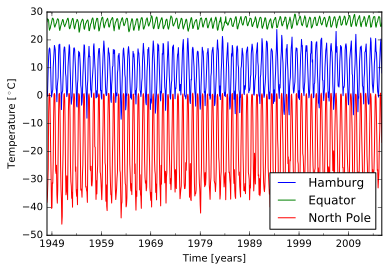

In [30]:
DF.plot()
xlabel('Time [years]')
ylabel('Temperature [$^\circ$C]')

## Calculate seasonal cycles

First example step by step 

In [31]:
periods = date.to_period(freq='M')
periods

PeriodIndex(['1948-01', '1948-02', '1948-03', '1948-04', '1948-05', '1948-06',
             '1948-07', '1948-08', '1948-09', '1948-10',
             ...
             '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10'],
            dtype='int64', length=814, freq='M')

In [32]:
D_seasonal=pd.DataFrame()
for k in DF.keys():
    y=DF[k]
    Seasonal=zeros(12)
    for m in range(12): # m is month index but month counts from 1 - 12 not 0 - 11
        Seasonal[m]=y[periods.month==m+1].mean()
    D_seasonal[k]=Seasonal # Add array to data frame

In [33]:
D_seasonal

,Hamburg,Equator,North Pole
0,-1.048331,27.056778,-33.049934
1,-0.142979,27.641066,-33.475239
2,3.473207,28.004725,-32.703217
3,8.225790,27.891445,-22.383791
4,13.390723,27.265486,-8.593779
5,16.545242,25.713150,0.227048
6,18.034508,24.584095,0.714374
7,17.418144,24.321541,-0.616614
8,13.809747,24.814531,-11.865003
9,9.046063,25.486557,-23.255203


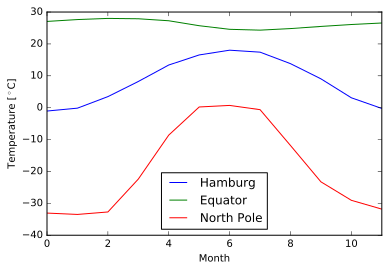

In [34]:
D_seasonal.plot()
xlabel('Month')
ylabel('Temperature [$^\circ$C]')

## Seasonal cycle with Pandas groupby function

We add another column to the DataFrame

In [35]:
DF['months']=periods.month
DF.head(3)

,Hamburg,Equator,North Pole,months
1948-01-01,1.576782,26.508759,-38.168091,1
1948-02-01,-0.183472,27.567596,-35.925858,2
1948-03-01,5.484833,27.415436,-30.902557,3


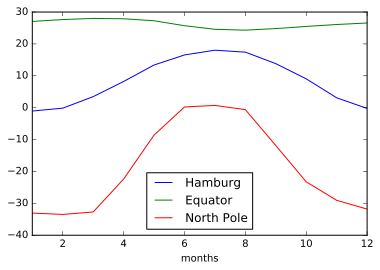

In [36]:
DF_seasonal=DF.groupby('months').mean()
DF_seasonal.plot()

## Just one line of code, that's it!

Now let's check the computational time

In [37]:
%%timeit
D_seasonal=pd.DataFrame()
for k in DF.keys():
    y=DF[k]
    Seasonal=zeros(12)
    for m in range(12): # m is month index but month counts from 1 - 12 not 0 - 11
        Seasonal[m]=y[periods.month==m+1].mean()
    D_seasonal[k]=Seasonal # Add array to data frame

100 loops, best of 3: 11.1 ms per loop


In [38]:
%%timeit
DF_seasonal=DF.groupby('months').mean()

1000 loops, best of 3: 805 µs per loop


# Calculate anomalies

In [39]:
N=len(periods)
Anomalies=zeros(N)
D_anom=pd.DataFrame()
for k in D.keys():
    for j,i in enumerate(date):
        Anomalies[j]=DF[k][i]-D_seasonal[k][i.month-1]
    D_anom[k]=pd.Series(Anomalies,index=date)

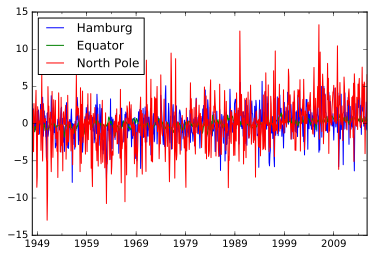

In [40]:
D_anom.plot()

In [24]:
#D_anom=D_anom.drop('months',1) # Remove column for plotting
#D_anom.plot()

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


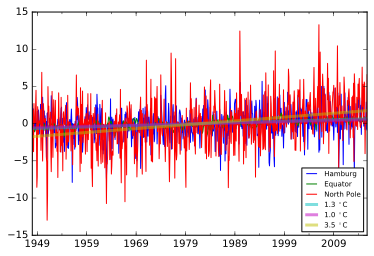

In [41]:
D_anom.plot()
for k in D.keys():
    #Add linear regression lines
    slope, intercept, r_value, p_value, std_err =stats.linregress(range(N),D_anom[k].values)
    fit=slope*range(N)+intercept
    S_fit=pd.Series(fit,index=date)
    S_fit.plot(linewidth=3,label='%0.1f $^\circ$C  '%(slope*N),alpha=0.5)
    legend(loc=4,fontsize=7)